<h1>Feature Engineering</h1><h2 align="center">Feature Selection</h2>

In [1]:
# import pandas as pd

# def sample(filepath_in, filepath_out, get_head, num_samples):
#     df = pd.read_csv(filepath_in)
#     if get_head:
#         df = df.head(num_samples)
#     else:
#         df = df.tail(num_samples)
#     df.to_csv(filepath_out, index=False)

# # filename = "class_covid_final_test"
# # filename = "class_covid_final_train"
# # filename = "class_credit_score_test"
# filename = "class_credit_score_train"
# filepath_in = f"../../../data/{filename}.csv"
# filepath_out = f"{filename}.csv"

# sample(filepath_in, filepath_out, True, 1000)

# Dataset 1

<h3>Dropping Low Variance Variables</h3>

In [2]:
from pandas import DataFrame, Index, read_csv
from dslabs_functions import (
    select_low_variance_variables,
    study_variance_for_feature_selection,
    apply_feature_selection,
    select_redundant_variables,
    study_redundancy_for_feature_selection,
)


def select_low_variance_variables(
    data: DataFrame, max_threshold: float, target: str = "class"
) -> list:
    summary5: DataFrame = data.describe()
    vars2drop: Index[str] = summary5.columns[
        summary5.loc["std"] * summary5.loc["std"] < max_threshold
    ]
    vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop
    return list(vars2drop.values)


target = "CovidPos"
file_tag = "covid"
# filename = "class_covid_final_train.csv"
filename = "../../../data/class_covid_final_train.csv"
train: DataFrame = read_csv(filename)

print("Original variables", train.columns.to_list())
vars2drop: list[str] = select_low_variance_variables(train, 3, target=target)
print("Variables to drop", vars2drop)

Original variables ['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']
Variables to drop ['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes

In [3]:
from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart


def study_variance_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    max_threshold: float = 1,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(i * lag, 3) for i in range(1, ceil(max_threshold / lag + lag))
    ]
    # results: dict[str, list] = {"NB": []}
    results: dict[str, list] = {"NB": [], "KNN": []}
    summary5: DataFrame = train.describe()
    for thresh in options:
        vars2drop: Index[str] = summary5.columns[
            summary5.loc["std"] * summary5.loc["std"] < thresh
        ]
        vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict[str, list] | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} variance study ({metric})",
        xlabel="variance threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_low_var_{metric}_study.png")
    return results


eval_metric = "accuracy"
test_filename = "../../../data/class_covid_final_test.csv"
# test_filename = "class_covid_final_train.csv"
test: DataFrame = read_csv(test_filename)

figure(figsize=(2 * HEIGHT, HEIGHT))
study_variance_for_feature_selection(
    train,
    test,
    target=target,
    max_threshold=3,
    lag=0.1,
    metric=eval_metric,
    file_tag=file_tag,
)
show()

In [ ]:
def apply_feature_selection(
    train: DataFrame,
    test: DataFrame,
    vars2drop: list,
    filename: str = "",
    tag: str = "",
) -> tuple[DataFrame, DataFrame]:
    train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
    train_copy.to_csv(f"{filename}_train_{tag}.csv", index=True)
    test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
    test_copy.to_csv(f"{filename}_test_{tag}.csv", index=True)
    return train_copy, test_copy


vars2drop: list[str] = select_low_variance_variables(
    train, max_threshold=1.2, target=target
)
train_cp, test_cp = apply_feature_selection(
    train, test, vars2drop, filename=f"data/{file_tag}", tag="lowvar"
)
print(f"Original data: train={train.shape}, test={test.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

Original data: train=(266652, 40), test=(114280, 40)
After low variance FS: train_cp=(266652, 14), test_cp=(114280, 14)


<h3>Dropping Redundant Variables</h3>

In [ ]:
from pandas import Series


def select_redundant_variables(
    data: DataFrame, min_threshold: float = 0.90, target: str = "class"
) -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop


print("Original variables", train.columns.values)
vars2drop: list[str] = select_redundant_variables(
    train, target=target, min_threshold=0.5
)
print("Variables to drop", vars2drop)

Original variables ['State' 'Sex' 'GeneralHealth' 'PhysicalHealthDays' 'MentalHealthDays'
 'LastCheckupTime' 'PhysicalActivities' 'SleepHours' 'RemovedTeeth'
 'HadHeartAttack' 'HadAngina' 'HadStroke' 'HadAsthma' 'HadSkinCancer'
 'HadCOPD' 'HadDepressiveDisorder' 'HadKidneyDisease' 'HadArthritis'
 'HadDiabetes' 'DeafOrHardOfHearing' 'BlindOrVisionDifficulty'
 'DifficultyConcentrating' 'DifficultyWalking' 'DifficultyDressingBathing'
 'DifficultyErrands' 'SmokerStatus' 'ECigaretteUsage' 'ChestScan'
 'RaceEthnicityCategory' 'AgeCategory' 'HeightInMeters'
 'WeightInKilograms' 'BMI' 'AlcoholDrinkers' 'HIVTesting' 'FluVaxLast12'
 'PneumoVaxEver' 'TetanusLast10Tdap' 'HighRiskLastYear' 'CovidPos']
Variables to drop []


In [ ]:
def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(min_threshold + i * lag, 3)
        for i in range(ceil((1 - min_threshold) / lag) + 1)
    ]

    df: DataFrame = train.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    results: dict[str, list] = {"NB": [], "KNN": []}
    for thresh in options:
        vars2drop: list = []
        for v1 in variables:
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            vars_corr.drop(v1, inplace=True)
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_redundancy_{metric}_study.png")
    return results


eval_metric = "accuracy"
# test_filename = "class_covid_final_test.csv"

test: DataFrame = read_csv(test_filename)

figure(figsize=(2 * HEIGHT, HEIGHT))
study_redundancy_for_feature_selection(
    train,
    test,
    target=target,
    min_threshold=0.25,
    lag=0.05,
    metric=eval_metric,
    file_tag=file_tag,
)
show()

In [ ]:
vars2drop: list[str] = select_redundant_variables(
    train, min_threshold=0.5, target=target
)
train_cp, test_cp = apply_feature_selection(
    train, test, vars2drop, filename=f"data/{file_tag}", tag="redundant"
)
print(f"Original data: train={train.shape}, test={test.shape}")
print(f"After redundant FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

Original data: train=(1000, 40), test=(1000, 40)
After redundant FS: train_cp=(1000, 40), test_cp=(1000, 40)


# Dataset 2

<h3>Dropping Low Variance Variables</h3>

In [ ]:
from pandas import DataFrame, Index, read_csv
from dslabs_functions import (
    select_low_variance_variables,
    study_variance_for_feature_selection,
    apply_feature_selection,
    select_redundant_variables,
    study_redundancy_for_feature_selection,
)


def select_low_variance_variables(
    data: DataFrame, max_threshold: float, target: str = "class"
) -> list:
    summary5: DataFrame = data.describe()
    vars2drop: Index[str] = summary5.columns[
        summary5.loc["std"] * summary5.loc["std"] < max_threshold
    ]
    vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop
    return list(vars2drop.values)


target = "Credit_Score"
file_tag = "services"
filename = "../../../data/class_credit_score_train.csv"
train: DataFrame = read_csv(filename)

print("Original variables", train.columns.to_list())
vars2drop: list[str] = select_low_variance_variables(train, 3, target=target)
print("Variables to drop", vars2drop)

Original variables ['ID', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Interest_Rate', 'NumofLoan', 'Delay_from_due_date', 'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'CreditMix', 'OutstandingDebt', 'CreditUtilizationRatio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'TotalEMIpermonth', 'Amountinvestedmonthly', 'MonthlyBalance', 'sin_month', 'cos_month', 'PaydayLoan', 'AutoLoan', 'Credit-BuilderLoan', 'StudentLoan', 'NotSpecified', 'MortgageLoan', 'HomeEquityLoan', 'DebtConsolidationLoan', 'PersonalLoan', 'spent', 'value_payments', 'Credit_Score']
Variables to drop ['Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Interest_Rate', 'NumofLoan', 'Delay_from_due_date', 'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'CreditMix', 'OutstandingDebt', 'CreditUtilizationRatio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'TotalEMIpermonth', 'Amountinvestedmonthly', 'Month

In [ ]:
from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart


def study_variance_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    max_threshold: float = 1,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(i * lag, 3) for i in range(1, ceil(max_threshold / lag + lag))
    ]
    # results: dict[str, list] = {"NB": []}
    results: dict[str, list] = {"NB": [], "KNN": []}
    summary5: DataFrame = train.describe()
    for thresh in options:
        vars2drop: Index[str] = summary5.columns[
            summary5.loc["std"] * summary5.loc["std"] < thresh
        ]
        vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict[str, list] | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} variance study ({metric})",
        xlabel="variance threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_low_var_{metric}_study.png")
    return results


eval_metric = "accuracy"
test_filename = "../../../data/class_credit_score_test.csv"

test: DataFrame = read_csv(test_filename)

figure(figsize=(2 * HEIGHT, HEIGHT))
study_variance_for_feature_selection(
    train,
    test,
    target=target,
    max_threshold=3,
    lag=0.1,
    metric=eval_metric,
    file_tag=file_tag,
)
show()

In [ ]:
def apply_feature_selection(
    train: DataFrame,
    test: DataFrame,
    vars2drop: list,
    filename: str = "",
    tag: str = "",
) -> tuple[DataFrame, DataFrame]:
    train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
    train_copy.to_csv(f"{filename}_train_{tag}.csv", index=True)
    test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
    test_copy.to_csv(f"{filename}_test_{tag}.csv", index=True)
    return train_copy, test_copy


vars2drop: list[str] = select_low_variance_variables(
    train, max_threshold=1.2, target=target
)
train_cp, test_cp = apply_feature_selection(
    train, test, vars2drop, filename=f"data/{file_tag}", tag="lowvar"
)
print(f"Original data: train={train.shape}, test={test.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

Original data: train=(1000, 40), test=(1000, 40)
After low variance FS: train_cp=(1000, 14), test_cp=(1000, 14)


<h3>Dropping Redundant Variables</h3>

In [ ]:
from pandas import Series


def select_redundant_variables(
    data: DataFrame, min_threshold: float = 0.90, target: str = "class"
) -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop


print("Original variables", train.columns.values)
vars2drop: list[str] = select_redundant_variables(
    train, target=target, min_threshold=0.5
)
print("Variables to drop", vars2drop)

Original variables ['State' 'Sex' 'GeneralHealth' 'PhysicalHealthDays' 'MentalHealthDays'
 'LastCheckupTime' 'PhysicalActivities' 'SleepHours' 'RemovedTeeth'
 'HadHeartAttack' 'HadAngina' 'HadStroke' 'HadAsthma' 'HadSkinCancer'
 'HadCOPD' 'HadDepressiveDisorder' 'HadKidneyDisease' 'HadArthritis'
 'HadDiabetes' 'DeafOrHardOfHearing' 'BlindOrVisionDifficulty'
 'DifficultyConcentrating' 'DifficultyWalking' 'DifficultyDressingBathing'
 'DifficultyErrands' 'SmokerStatus' 'ECigaretteUsage' 'ChestScan'
 'RaceEthnicityCategory' 'AgeCategory' 'HeightInMeters'
 'WeightInKilograms' 'BMI' 'AlcoholDrinkers' 'HIVTesting' 'FluVaxLast12'
 'PneumoVaxEver' 'TetanusLast10Tdap' 'HighRiskLastYear' 'CovidPos']
Variables to drop []


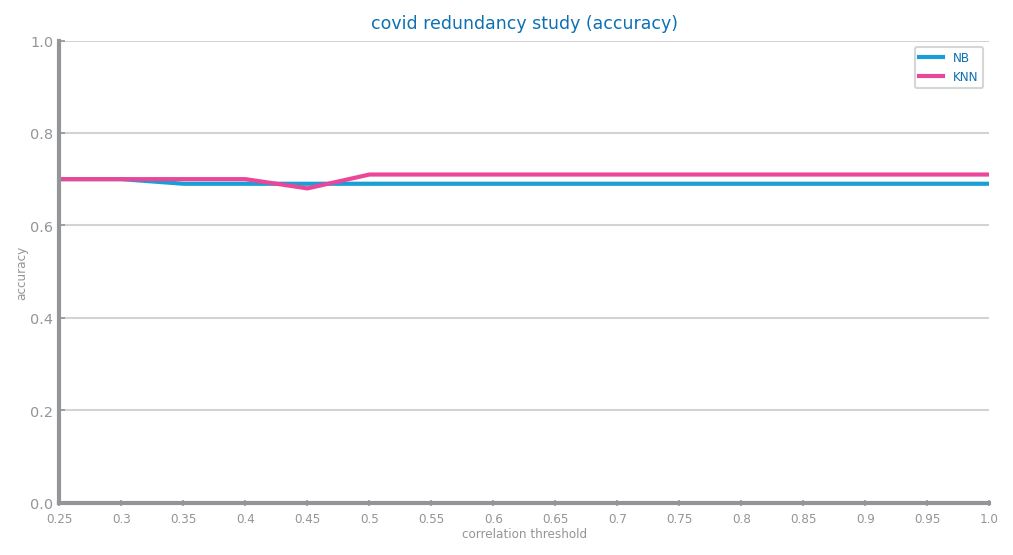

In [ ]:
def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(min_threshold + i * lag, 3)
        for i in range(ceil((1 - min_threshold) / lag) + 1)
    ]

    df: DataFrame = train.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    results: dict[str, list] = {"NB": [], "KNN": []}
    for thresh in options:
        vars2drop: list = []
        for v1 in variables:
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            vars_corr.drop(v1, inplace=True)
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_redundancy_{metric}_study.png")
    return results


# eval_metric = "accuracy"
# test_filename = "class_covid_final_test.csv"

test: DataFrame = read_csv(test_filename)

figure(figsize=(2 * HEIGHT, HEIGHT))
study_redundancy_for_feature_selection(
    train,
    test,
    target=target,
    min_threshold=0.25,
    lag=0.05,
    metric=eval_metric,
    file_tag=file_tag,
)
show()

In [ ]:
vars2drop: list[str] = select_redundant_variables(
    train, min_threshold=0.5, target=target
)
train_cp, test_cp = apply_feature_selection(
    train, test, vars2drop, filename=f"data/{file_tag}", tag="redundant"
)
print(f"Original data: train={train.shape}, test={test.shape}")
print(f"After redundant FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

Original data: train=(1000, 40), test=(100, 40)
After redundant FS: train_cp=(1000, 40), test_cp=(100, 40)
